## Define helper functions
### Biopython style `UstacksCommandLine` class

In [201]:
#%matplotlib inline
import sys
import numpy as np 
import collections
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as py
import os
import csv
from collections import Counter
import re
import subprocess
from Bio.Application import _Option, AbstractCommandline, _Switch 
import gzip
import pprint

## Plotting parameters ##

plt.rcParams["xtick.labelsize"] = 'medium'
plt.rcParams["ytick.labelsize"] = 'medium'
plt.rcParams['figure.figsize'] = (14.0, 12.0)


In [590]:
class UstacksCommandLine(AbstractCommandline):
    def __init__(self, cmd="ustacks", **kwargs):
        """
        # Any ustacks option and switch
        >>> cline_args = {'t': 'fastq',
        ...               'f': '../../dan_data/OBY01_1.fil.fq_1',
        ...               'o': '../../dan_data/OBY01_1.fi/M_tests/M_1',
        ...               'i': 1,
        ...               'm': 6,
        ...               'M': 1,
        ...               'p': 3,
        ...               'r': True,
        ...               'd': True}
        
        # This creates a command line object
        >>> ustacks_cline = UstacksCommandLine(**cline_args)
        
        # This prints a string representation
        >>> print ustacks_cline
        ustacks -t fastq -f ../../dan_data/OBY01_1.fil.fq_1 -o ../../dan_data/OBY01_1.fi/M_tests/M_1 -i 1 -m 6 -M 1 -p 3 -r -d
        
        # This runs ustacks
        >>> stdout, stderr = ustacks_cline()
        
        # This prints the first line in the allele files of the example reuslts
        >>> with open('../../dan_data/OBY01_1.fi/M_tests/M_1/OBY01_1.fil.alleles.tsv') as alleles:
        ...     print alleles.readlines()[1].rstrip().split()
        ['0', '1', '1', 'C', '78.04', '167']
        """
        
        self.parameters = [
            _Option(["-t", "t"],
                    "input file Type. Supported types: fasta, fastq, gzfasta, or gzfastq",
                    is_required=True,
                    checker_function=lambda value : value in ["fasta", 
                                                              "fastq",
                                                              "gzfasta",
                                                              "gzfastq"],
                    equate=False),
            _Option(["-f", "f"],
                    "input file path",
                    is_required=True,
                    filename=True,
                    equate=False),
            _Option(["-o", "o"],
                    "output path to write results",
                    is_required=False,
                    filename=True,
                    equate=False),
            _Option(["-i", "i"],
                    "SQL ID to insert into the output to identify this sample",
                    is_required=False,
                    equate=False),
            _Option(["-m", "m"],
                    "Minimum depth of coverage required to create a stack (default 3)",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),
            _Option(["-M", "M"],
                    "Maximum distance (in nucleotides) allowed between stacks (default 2)",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),
            _Option(["-N", "N"],
                    "Maximum distance allowed to align secondary reads to primary stacks (default: M + 2)",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),
            _Switch(["-R", "R"],
                    "retain unused reads"), 
            _Switch(["-H", "H"],
                    "disable calling haplotypes from secondary reads"),
            _Option(["-p", "p"],
                    "enable parallel execution with num_threads threads",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),  
            _Switch(["-h", "h"],
                    "display this help messsage"),
            
            # Stack assembly options:
            _Switch(["-r", "r"],
                    "enable the Removal algorithm, to drop highly-repetitive stacks (and nearby errors) from the algorithm"), 
            _Switch(["-d", "d"],
                    "enable the Deleveraging algorithm, used for resolving over merged tags"),
            _Option(["--max_locus_stacks", "-max_locus_stacks","max_locus_stacks"],
                    "maximum number of stacks at a single de novo locus (default 3)",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),
            
            # Model options:
            _Option(["--model_type", "-model_type","model_type"],
                    "either 'snp' (default), 'bounded', or 'fixed'",
                    is_required=False,
                    checker_function=lambda value : value in ["snp", 
                                                              "bounded",
                                                              "fixed"],
                    equate=False),
            
            # For the SNP or Bounded SNP model: 
            _Option(["--alpha", "-alpha","alpha"],
                    "chi square significance level required to call a heterozygote or homozygote, either 0.1, 0.05 (default), 0.01, or 0.001",
                    is_required=False,
                    checker_function=lambda value : value in [0.1, 
                                                              0.05,
                                                              0.01,
                                                              0.001],
                    equate=False),
            
            
            # For the Bounded SNP model:
            _Option(["--bound_low", "-bound_low","bound_low"],
                    "lower bound for epsilon, the error rate, between 0 and 1.0 (default 0)",
                    is_required=False,
                    checker_function=lambda value : 0 <= value <= 1,
                    equate=False),
            _Option(["--bound_high", "-bound_high","bound_high"],
                    "upper bound for epsilon, the error rate, between 0 and 1.0 (default 1)",
                    is_required=False,
                    checker_function=lambda value : 0 <= value <= 1,
                    equate=False),
            
            # For the Fixed model:
            _Option(["--bc_err_freq", "-bc_err_freq","bc_err_freq"],
                    "specify the barcode error frequency, between 0 and 1.0",
                    is_required=False,
                    checker_function=lambda value : 0 <= value <= 1,
                    equate=False)
                           ]
        AbstractCommandline.__init__(self, cmd, **kwargs) 

## With this uncommented, the examples in the 
## docstring will be run and the outputs compared
#if __name__ == "__main__":
#    import doctest
#    doctest.testmod()

## Define the incrementation and helper functions

In [657]:
a = []

b = ("c","d")
c = ("e","f")
d = ("c","d")
print a

[]


In [658]:
a.append(b)
print a
for i in b,c:
    if i in a:
        print i, True
    else:
        print i, False

[('c', 'd')]
('c', 'd') True
('e', 'f') False


In [769]:
## this function takes the string to be searched and a dictionary of replacements ------------------------------------------------------------
def replace_all(text,dic): 
    for i, j in dic.iteritems(): 
        text = text.replace(i,j) ## for each dictionary entry, replace the "key" with the "value" in the text
    return text


## A cool little helper function for "natural sorting". (no idea how it works though!) -------------------------------------------------------
def natural_key(string_): 
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]


## Function to count the length of a file ----------------------------------------------------------------------------------------------------
    
def file_len(data):
    for i, l in enumerate(data):
        pass
    return i + 1
    
## Function for generating random colour maps for the samples

def random_colour_generator(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in xrange(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap


## Function to make and run the command line. -----------------------------------------------------------------------------
def make_and_run_command_line(param, value, parent_dir_path, sample, file_format, threads, ID, run_switch):
    
    """
    Makes and runs the command line using the UstacksCommandLine class
    """
    
    # fixed values
    default = {'M': 3, 
               'm': 6}
              # MS as stacks default (doesn't need to be specified in command line)
    
    batch_params = {}
    
    sample_name = sample.split(".")[0]
    
    dirname = '%s%s/%s_tests/%s_%i'%(parent_dir_path,sample_name,param,param,value) ## make output directory
            
    # make command line
    args = {}
    args['t'] = file_format
    args['p'] = threads
    args['d'] = True
    args['r'] = True
    args['i'] = str(ID)
    args['f'] = "%s%s"%(parent_dir_path,str(sample))
    args['o'] = dirname
        
    if param == 'MS':
        args['max_locus_stacks'] = value
        args.update(default)
    else:
        args[param] = value
        for key in default:
            if not key == param:
                args[key] = default[key]
                    
    cline = UstacksCommandLine(**args)
    print str(cline)
        
    if run_switch == 1:
        stderr, stdout = cline()        
        
    batch_params["%s_%i"%(args['i'], value)] = args
        
        
    return cline, batch_params      




### This function gets information on the blacklisted or deleveraged loci in stacks - useful for looking at problems associated with repeats.

def blacklister(file_name):
    
    Blacklisted_lumberjacks = 0
    Blacklisted_multistack = 0
    Deleveraged_Lumberjacks = 0
    Deleveraged_mulitstacks = 0
    Deleved_blacklisted_multistacks = 0
    
    Blacklisted_lumberjacks_list = []
    Blacklisted_multistack_list = []
    Deleveraged_lumberjacks_list = []
    Deleveraged_mulitstacks_list = []
    Deleved_blacklisted_multistacks_list = []

    if file_name.endswith(".gz"):
        csvfile = gzip.open(file_name, 'rb')
    else:
        csvfile = open(file_name, 'rb')
    csvread = csv.reader(csvfile, delimiter ="\t") ## read csv in 
    
    for line in csvread:
        if "consensus" in line:
            tag_ID = line[2]
            ## if tag had very high coverage and could not be deleveraged
            if line[10] == "0" and line[11] == "1" and line[12] == "1":
                Blacklisted_lumberjacks += 1
                Blacklisted_lumberjacks_list.append(tag_ID)
            ## if tag was a multistack but could not be deleveraged
            elif line[10] == "0" and line[11] == "1" and line[12] == "0":
                Blacklisted_multistack += 1
                Blacklisted_multistack_list.append(tag_ID)
            ## if tag was a lumberjack and could be deleveraged
            elif line[10] == "1" and line[11] == "0" and line[12] == "1":
                Deleveraged_Lumberjacks += 1
                Deleveraged_lumberjacks_list.append(tag_ID)
            ## if tag was a multistack and could be deleveraged
            elif line[10] == "1" and line[11] == "0" and line[12] == "0":
                Deleveraged_mulitstacks += 1
                Deleveraged_mulitstacks_list.append(tag_ID)
            ## if tag was a multistack, passed the deleveraging but was blacklisted for another reason. . . ?
            elif line[10] == "1" and line[11] == "1" and line[12] == "0":
                Deleved_blacklisted_multistacks += 1
                Deleved_blacklisted_multistacks_list.append(tag_ID)

   
    print "\tNumber of un-deleveraged lumberjacks blacklisted = %s" % (Blacklisted_lumberjacks)
    print "\tNumber of un-deleveraged multistack loci blacklisted = %s" % (Blacklisted_multistack)
    print "\tNumber of deleveraged lumberjacks = %s" % (Deleveraged_Lumberjacks)
    print "\tNumber of deleveraged multistack loci = %s" % (Deleveraged_mulitstacks)
    print "\tNumber of deleveraged but still blacklisted multistack loci = %s" % (Deleved_blacklisted_multistacks)
    
    return Blacklisted_lumberjacks_list, Blacklisted_multistack_list, Deleveraged_lumberjacks_list, Deleveraged_mulitstacks_list, Deleved_blacklisted_multistacks_list 
    
    

## This function counts the number of tags in a file ------------------------------------------------------------------------------

def Tag_counter(tags_file, parameter, value):   
    
    """
    Counts the number of tags found by the ustacks module of Stacks in a given tag.tsv file.
    It works by simply counting the number of lines with the work "consensus" in them in the tags file. 
    
    Arguments:
        sample_directory - the parent test directory containing the intitial fastq files.
        parameter - the parameter being addressed. 
    
    """
    
    ## get file names and paths
    tag_data = {}
    param_output_path = tags_file.rpartition("/")[0]
                                
    if tags_file.endswith(".gz"):
        data_file = gzip.open(tags_file, 'r')
    else: 
        data_file = open(tags_file, 'r') ## looking in tags files for all the tests for this parameter
    
    total_tags = 0
    tag_tally = 0
    N_blacklisted = 0
                
    for line in data_file.readlines()[1:]:
        if 'consensus' in line:
            total_tags += 1
            tag_id = str(line.split()[2])
            blacklist_flag = str(line.split()[8])
                        
            ## check that loci weren't blacklisted
            if blacklist_flag == "1":
                N_blacklisted += 1
            else:
                tag_tally +=1
                            
    print "\t%s at %s = %s Total_tags = %s, Good tags = %s, N blacklisted = %s" % (tags_file.rpartition("/")[2], parameter, value, total_tags, tag_tally, N_blacklisted)
    
    return tag_tally



def Tag_plotter(Outputs_dict):
    
    
    colmap = random_colour_generator(100, verbose=False)
    
    ## Count number of plots needed
    
    params_needed = []
    plots_needed = []
    samples_needed = []

    for sample in Outputs_dict: ## sample level
        for param in Outputs_dict[sample]: ## each param within sample
            for value in Outputs_dict[sample][param]:
                if "N_tags" in Outputs_dict[sample][param][value].keys():
                    plots_needed.append((sample, param))
                    params_needed.append(param)

    params_needed = set(params_needed)
    plots_needed = set(plots_needed)
    Total_subplots_needed = len(plots_needed) + len(params_needed)
    
    n_rows = (np.round(Total_subplots_needed/3)+1)
    n_cols = 3

    sample_plot_index = 1
    sample_colour_index = 1
    param_tracker = []
    
    fig = plt.figure(figsize= (20,Total_subplots_needed*2))
    #fig.subplots_adjust(hspace = 0.5, wspace = 0.25) ## adjust subplots

    sample_counter = 0
    param_value_counter = 0



    for sample in Outputs: ## sample level
        print "plotting tags for ", sample
        for param in Outputs[sample]:
            if (sample, param) in plots_needed:
            
            ## get the index right for the comparison plots

                if param == "M":
                    comparison_plot_index = Total_subplots_needed
                    
                elif param == "m" and not "M" in params_needed:
                    comparison_plot_index = Total_subplots_needed
                    
                elif param == "m" and "M" in params_needed:
                    comparison_plot_index = Total_subplots_needed -1
                    
                elif param == "MS" and "M" not in params_needed and "m" not in params_needed:
                    comparison_plot_index = Total_subplots_needed
                    
                elif param == "MS" and "M" in params_needed and "m" not in params_needed:
                    comparison_plot_index = Total_subplots_needed -1
                    
                elif param == "MS" and "M" not in params_needed and "m" in params_needed:
                    comparison_plot_index = Total_subplots_needed -1
                    
                elif param == "MS" and "M" in params_needed and "m" in params_needed:
                    comparison_plot_index = Total_subplots_needed -2
                    

                ## Make the data

                x = []
                y = []

                for value in Outputs[sample][param]: ## each value for each param in each sample

                    if "N_tags" in Outputs[sample][param][value]:
                        x.append(value)
                        y.append(Outputs[sample][param][value]["N_tags"])

                ## If there is data present, plot it

                if len(y) > 0:
                   
                    fig.add_subplot(n_rows,n_cols,sample_plot_index)
                    plt.plot(x,y, color = (colmap(sample_colour_index)),linewidth = 1.5,markersize = 3, marker = "o")
                    plt.title(sample)
                    plt.xlabel("%s Value" % (param), fontsize = 10)
                    plt.ylabel("Number of tags", fontsize = 10)

                    ## Combined plot
                    fig.add_subplot(n_rows,n_cols,comparison_plot_index)
                    plt.plot(x,y, color =(colmap(sample_colour_index)), label = sample, linewidth = 1.5, markersize = 3,  marker = "o")
                    plt.title("All")
                    plt.xlabel("%s Value" % (param), fontsize = 10)
                    plt.ylabel("Number of tags", fontsize = 10)

                    sample_plot_index +=1
                else:
                    pass
        sample_colour_index += 1
        
    #plt.tight_layout()
    fig.suptitle("Change in Tag Number with Incrementing %s values" % param) 
    fig.savefig("%s/%s" % (Setup_dict["parent_directory"], "Tag_counts.pdf"), format = "pdf")
    fig.show()
    
    

## This function counts the coverage at each non-blacklisted locus in a ustacks tags.tsv output file. 
    
def coverage_counter(file_name): ## Need to add help info to this and annotate properly!!
    
    """
    
    This function calculates the coverage of each tag in the ustacks tags.tsv output
    as long as that locus has not been blacklisted. It outputs a text file containing all 
    tag IDs and coverage values, as well as a histogram of the tag coverage into the same 
    directory as the input file.
    
    - filename: the full path to the tags.tsv file
    
    This function works in conjuction with coverage_counter_looper and returns a dictionary for this.
    
    """    
    
    csvcol3 = []        
    
    if file_name.endswith(".gz"):
        csvfile = gzip.open(file_name, 'rb')
    else: 
        csvfile = open(file_name, 'rb') 
    
    csvread = csv.reader(csvfile, delimiter ="\t") ## read csv in    
    blacklisted_loci = []
    
    print "\n Cov counter: %s" % file_name
    
    sample_name = file_name.rpartition("/")[2].split(".")[0]
    tags_file_parameter = file_name.rpartition("/")[0].rpartition("/")[2].split("_")[0]
    tags_file_val = file_name.rpartition("/")[0].rpartition("/")[2].split("_")[1]
    
    
    n_blacklisted = 0
    n_counted = 0
    for line in csvread:
        
        if not line[0].startswith('#'): # outputs in new version of stacks start with a comment 
            tag_ID = line[2]
            
            if "consensus" in line and line[11] == "1": ## Check that the locus is not blacklisted!
                n_blacklisted += 1
                blacklisted_loci.append(tag_ID)
            if "model" not in line and "consensus" not in line:
                n_counted += 1
                csvcol3.append(tag_ID) ## for each read, add its tag ID to a list.
    -
    
    coverage_count = collections.Counter(csvcol3) ## count the occurance of each tag ID in the list to get read depths per locus
    
    
    good_counts = {}
    
    ## Now remove coverage counts for loci in the blacklist. 
    
    for locus in coverage_count: 
        if locus not in blacklisted_loci:
            good_counts[locus] = coverage_count[locus]
    
    
    ## OUTPUTS -------------------------
    
    outdir = file_name.rpartition("/")[0] ## same directory as the input file
    f = open("%s/Coverage data.txt" % outdir, 'w') ## txt file for coverage data    
        
    for i,j in good_counts.iteritems():
        f.write("%s\t%s\n" % (str(i), str(j) )) ## write the coverage data to the txt file
    
    ## Can make individual histograms for each sample if you want. Just un comment this section ------
    
    x = good_counts.values()
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #ax.hist(x, bins=max(x), range = (1, np.mean(x)+(2*np.std(x))))
    #ax.set_title("%s, %s = %s" % (sample_name, tags_file_parameter, tags_file_val), fontsize = 15) ####
    #ax.set_xlabel("Coverage", fontsize = 12)
    #ax.set_ylabel("Frequency", fontsize = 12)
    #ax.text(0.6, 0.95, "Mean tag coverage = %s (+/- %s)" % (np.round(np.mean(x),2),np.round(np.std(x),2)) , transform=ax.transAxes, fontsize = 13)
    #plt.savefig("%s/Coverage.pdf" % outdir)
    
    #plt.show()
    #plt.close()
    
    f.close()
    
    
    
    print "Number of blacklisted loci = %s" % n_blacklisted
    print "Number of loci counted = %s" % len(good_counts)
    print "Mean and SD of coverage = %s (+/- %s)" % (np.round(np.mean(x),2),np.round(np.std(x),2))
    #print "Output directory =", outdir
    
    return good_counts


## Coverage plotter -----------------------------------------------------------------------------------------------------------------

def Coverage_plotter(Outputs):

    colmap = random_colour_generator(100, verbose=False)
    
    ## Count number of plots needed
    
    params_needed = []
    plots_needed = []
    samples_needed = []

    for sample in Outputs: ## sample level
        for param in Outputs[sample]: ## each param within sample
            for value in Outputs[sample][param]:
                if "N_tags" in Outputs[sample][param][value].keys():
                    plots_needed.append((sample, param))
                    params_needed.append(param)

    params_needed = set(params_needed)
    plots_needed = set(plots_needed)
    Total_subplots_needed = len(plots_needed) + len(params_needed)
    
    n_rows = (np.round(Total_subplots_needed/3)+1)
    n_cols = 3

    sample_plot_index = 1
    sample_colour_index = 1
    param_tracker = []
    
    fig = plt.figure(figsize= (20,Total_subplots_needed*2))
    #fig.subplots_adjust(hspace = 0.5, wspace = 0.25) ## adjust subplots

    sample_counter = 0
    param_value_counter = 0
    

    sample_plot_index = 1
    sample_colour_index = 1
    
    
    param_tracker = []

    fig = plt.figure(figsize= (20,Total_subplots_needed*2))
    #fig = plt.figure()
    #fig.subplots_adjust(hspace = 0.5, wspace = 0.25) ## adjust subplots

    sample_counter = 0
    param_value_counter = 0



    ## Individual plots per value

    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.5, wspace = 0.25) ## adjust subplots

    sample_counter = 0
    param_value_counter = 0

    for sample in Outputs: ## sample level
        sample_name = sample.split(".")[0]    
        for param in Outputs[sample]:
            if (sample,param) in plots_needed:

                ## get the index right for the comparison plots

                if param == "M":
                    comparison_plot_index = Total_subplots_needed

                elif param == "m" and not "M" in params_needed:
                    comparison_plot_index = Total_subplots_needed

                elif param == "m" and "M" in params_needed:
                    comparison_plot_index = Total_subplots_needed -1

                elif param == "MS" and "M" not in params_needed and "m" not in params_needed:
                    comparison_plot_index = Total_subplots_needed

                elif param == "MS" and "M" in params_needed and "m" not in params_needed:
                    comparison_plot_index = Total_subplots_needed -1

                elif param == "MS" and "M" not in params_needed and "m" in params_needed:
                    comparison_plot_index = Total_subplots_needed -1

                elif param == "MS" and "M" in params_needed and "m" in params_needed:
                    comparison_plot_index = Total_subplots_needed -2


                ## Make the data

                x = [] ## parameter values
                y = []
                mean_y = []
                std_y = []
                e = []

                upper_95 = 0
                x_labs = []

                for value in Outputs[sample][param]: ## each value for each param in each sample
                    if "Coverage" in Outputs[sample][param][value]:
                        
                        x.append(value)
                        y.append(Outputs[sample][param][value]["Coverage"].values())
                        mean_y.append(np.mean(Outputs[sample][param][value]["Coverage"].values()))
                        std_y.append(np.std(Outputs[sample][param][value]["Coverage"].values()))
                        x_labs.append(int(value))
                        if np.percentile(Outputs[sample][param][value]["Coverage"].values(), 95) > upper_95:
                            upper_95 = np.percentile(Outputs[sample][param][value]["Coverage"].values(), 95)
                    else:
                        print "Coverage data not in", sample, param, value
                ## If there is data present, plot it
                print x
                print len(y)
                if len(y) > 0:

                    ax = plt.subplot(n_rows,n_cols,sample_plot_index)
                    ax.set_ylim(0, upper_95)
                    bp = ax.boxplot(y, labels= x_labs) # '%so-.' % (colours[sample_colour_and_plot_index]),linewidth = 1.5,markersize = 3, 
                    ax.set_title("%s" % (sample_name))
                    ax.set_xlabel("%s Value" % (param), fontsize = 10)
                    ax.set_ylabel("Tag coverage", fontsize = 10)

                    ## Combined plot
                    ax1 = plt.subplot(n_rows,n_cols,comparison_plot_index)
                    ax1.set_xlim(0, max(int(i) for i in x_labs)+2)
                    #ax1.set_xticklabels(range(0, max(int(i) for i in x)+2, 1), [str(i) for i in range(0, max(int(i) for i in x_labs)+1, 1)])
                    ax1.plot(x, mean_y, label = sample, color =(colmap(sample_colour_index)), marker = "o")
                    ax1.set_title("Comparison of mean tag coverage")
                    ax1.set_xlabel("%s Value" % (param), fontsize = 10)
                    ax1.set_ylabel("Mean tag coverage", fontsize = 10)

                    ax1.legend(loc = 2, fontsize = 10)
                    
                    sample_plot_index += 1
                else:
                    pass
                
        sample_colour_index += 1

    fig.suptitle("Change in Mean tag coverage with Incrementing parameter values") 
    fig.savefig("%s/%s" % (Setup_dict["parent_directory"], "Coverage.pdf"), format = "pdf")
    #fig.show()

    
    

SyntaxError: invalid syntax (<ipython-input-769-4ef56dfd091f>, line 399)

In [756]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    An arbitrary number of *x*, *y*, *fmt* groups can be
    specified, as in::
    
        a.plot(x1, y1, 'g^', x2, y2, 'g-')
    
    Return value is a list of lines that were added.
    
    By default, each line is assigned a different color specified by a
    'color cycle'.  To change this behavior, you can 

{ 'Pnig_1.fq': { 'M': { 2: { }, 3: { }}},
  'Pnig_20.fq': { 'M': { 2: { }, 3: { }}},
  'Pnig_30.fq': { 'M': { 2: { }, 3: { }}}}
/home/djeffrie/Data/Pnig_RAD/Incremental_tests/Pnig_30/M_tests/M_2
ustacks -t fastq -f /home/djeffrie/Data/Pnig_RAD/Incremental_tests/Pnig_30.fq -o /home/djeffrie/Data/Pnig_RAD/Incremental_tests/Pnig_30/M_tests/M_2 -i 1 -m 6 -M 2 -p 7 -r -d
Tags file = /home/djeffrie/Data/Pnig_RAD/Incremental_tests/Pnig_30/M_tests/M_2/Pnig_30.tags.tsv

### Getting blacklisted loci ###

	Number of un-deleveraged lumberjacks blacklisted = 158
	Number of un-deleveraged multistack loci blacklisted = 196
	Number of deleveraged lumberjacks = 0
	Number of deleveraged multistack loci = 6616
	Number of deleveraged but still blacklisted multistack loci = 1432

### Counting number of tags ###

	Pnig_30.tags.tsv at M = 2 Total_tags = 56681, Good tags = 54895, N blacklisted = 1786

### Calculating coverage of retained tags ###


 Cov counter: /home/djeffrie/Data/Pnig_RAD/Incremental_tests/

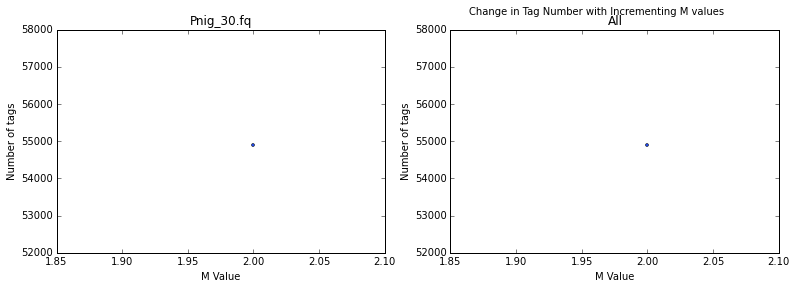

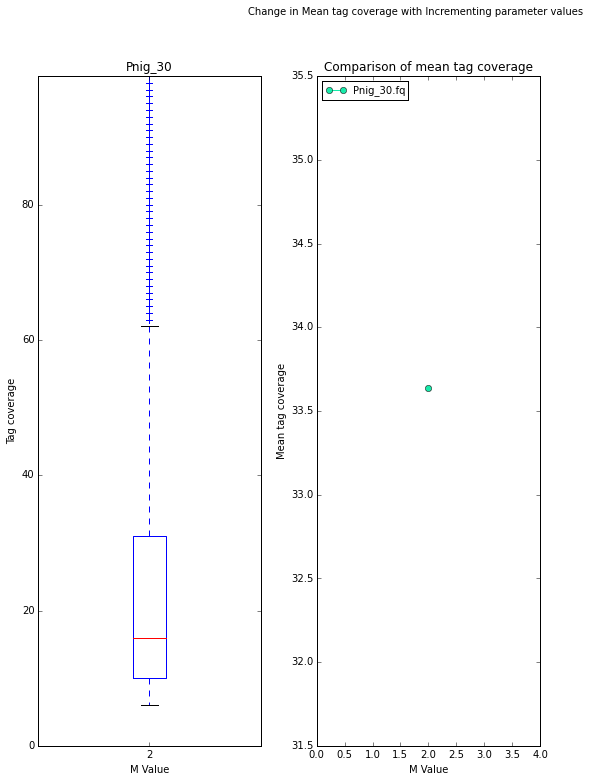

In [768]:
Outputs = IncreMental_U(Setup_dict)

In [746]:
def IncreMental_U(Setup_dict):
    
    Master_dict = {} ## All outputs go in here!

    ## Find the samples -----------------------------------------------------------------------------------------------------|||
    
    file_formats = []

    for i in os.listdir(Setup_dict["parent_directory"]):
        if i.endswith(".fq_1") or i.endswith(".fq") or i.endswith("1.fastq"):
            Master_dict[i] = {}
            file_formats.append("fastq")

        elif i.endswith(".fq_1.gz") or i.endswith(".fq.gz") or i.endswith("1.fastq.gz"):
            Master_dict[i] = {}
            file_formats.append("gzfastq")

    
    ## Check file formats are ok --------------------------------------------------------------------------------------------|||

    file_formats = list(set(file_formats))

    if len(file_formats) > 1:
        sys.exit("Inconsistent file format, please make sure all files are of the same format")
    else:
        file_format = file_formats[0]
            
            
    ## make the structure of the master dictionary --------------------------------------------------------------------------|||
    
    for sample in Master_dict:
        for parameter in Setup_dict["parameters"]:
            Master_dict[sample][parameter] = {}
            for value in Setup_dict["parameters"][parameter]:
                Master_dict[sample][parameter][value] = {}

    pp = pprint.PrettyPrinter(indent=2)
    pp.pprint(Master_dict)


    ## Make the directories and the command line scripts and run them -------------------------------------------------------|||
    run_cline = Setup_dict["run_cline_switch"]
    analysis_settings = {}
    ID = 1

    for sample in Master_dict.keys():
        sample_name = sample.split(".")[0]
        test_params = Master_dict[sample].keys()

        if file_format == "gzfastqc":
            tags_file_name = "%s.tags.tsv.gz" % sample.split(".")[0]
        else:
            tags_file_name = "%s.tags.tsv" % sample.split(".")[0]



        ## Make the necassary directories -----------------------------------------------------
        
        for param in Master_dict[sample]:

            for val in Master_dict[sample][param]:

                dirname = '%s%s/%s_tests/%s_%i'%(Setup_dict["parent_directory"],sample_name,param,param,val)
                print dirname
                if not os.path.exists(dirname):
                    try:
                        os.makedirs(dirname)
                    except:
                        os.mkdir(dirname)

                ## Now make and run the command lines for the sample --------------------------

                cline, analysis_settings[str(ID)] = make_and_run_command_line(param, val, Setup_dict["parent_directory"], sample, file_format, Setup_dict["threads"], ID, run_cline)

                for root, dirs, files in os.walk(Setup_dict["parent_directory"]):
                    for fil in files:
                        if "tags.tsv" in fil and sample_name in fil and "%s_%s" % (param, val) in root:
                            tagsfilepath = "%s/%s" % (root, fil)

                            print "Tags file =", tagsfilepath
 

                            ## Look at the blacklisting ---------------------------------------

                            print "\n### Getting blacklisted loci ###\n"
                            
                            Master_dict[sample][param][val]["blacklists"] = {} 
                            Master_dict[sample][param][val]["blacklists"]["bl_lumbers"], Master_dict[sample][param][val]["blacklists"]["bl_multistak"], Master_dict[sample][param][val]["blacklists"]["dl_lumbs"], Master_dict[sample][param][val]["blacklists"]["dl_multistak"], Master_dict[sample][param][val]["blacklists"]["dl_bl_multistak"] = blacklister(tagsfilepath)

                            ## Count the number of tags ---------------------------------------

                            print "\n### Counting number of tags ###\n"
                            Master_dict[sample][param][val]["N_tags"] = Tag_counter(tagsfilepath, param, val)


                            ## get the coverage -----------------------------------------------

                            print "\n### Calculating coverage of retained tags ###\n"
                            Master_dict[sample][param][val]["Coverage"] = coverage_counter(tagsfilepath)


        ID += 1  ## INCREMENT the ID for the next sample
    
    
    #------------------------------------------------------------------------------------------------------------------------------|||
    ### Plotting the outputs ## ---------------------------------------------------------------------------------------------------|||
    #------------------------------------------------------------------------------------------------------------------------------|||
    

    ## Number of loci blacklisted ----------------------------------
    
    
    
    ## Number of tags -----------------------------------------------
    Tag_plotter(Master_dict)
    
    
    ## Coverage -----------------------------------------------------
    Coverage_plotter(Master_dict)
      

    return Master_dict
    

In [747]:
## INPUT PARAMETERS HERE -----------------------------------------

parameters = ["M"]                                             ## List, eg ["M", "m", "MS"]. If only testing 1 param, this must still be a list e.g. ["M"]
M_vals =   [2,3]                                                    ## List, eg range(1,5,1) this would give [1,2,3,4]
m_vals =   [2,3,4,5]                                                ## List, eg range(1,5,1) this would give [1,2,3,4]
MS_vals =  [2,3,4]                                                    ## List, eg range(1,5,1) this would give [1,2,3,4]
threads =  7                                                        ## Int. eg 7
parent_dir = "/home/djeffrie/Data/Pnig_RAD/Incremental_tests/"      ## Absolute Dir containing the demultiplexed raw read fasta/fastq files
run_cline_switch = 0                                                ## to switch on (1) to run stacks cline or off (0) to run pipeline on existing outputs



## Making input dictionary --------------------------------------

Setup_dict = {}
Setup_dict["parameters"] = {}
Setup_dict["threads"] = threads
Setup_dict["parent_directory"] = parent_dir
Setup_dict["run_cline_switch"] = run_cline_switch

for param in parameters:
    if "M" in param:
        Setup_dict["parameters"][param] = M_vals
    if "m" in param:
        Setup_dict["parameters"][param] = m_vals
    if "MS" in param:
        Setup_dict["parameters"][param] = MS_vals

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(Setup_dict)

{ 'parameters': { 'M': [2, 3]},
  'parent_directory': '/home/djeffrie/Data/Pnig_RAD/Incremental_tests/',
  'run_cline_switch': 0,
  'threads': 7}


### Run the pipeline here:

### On the basis of the above results, decide on the Ustacks parameters to use here, and then run cstacks using these for use in Incremental_C

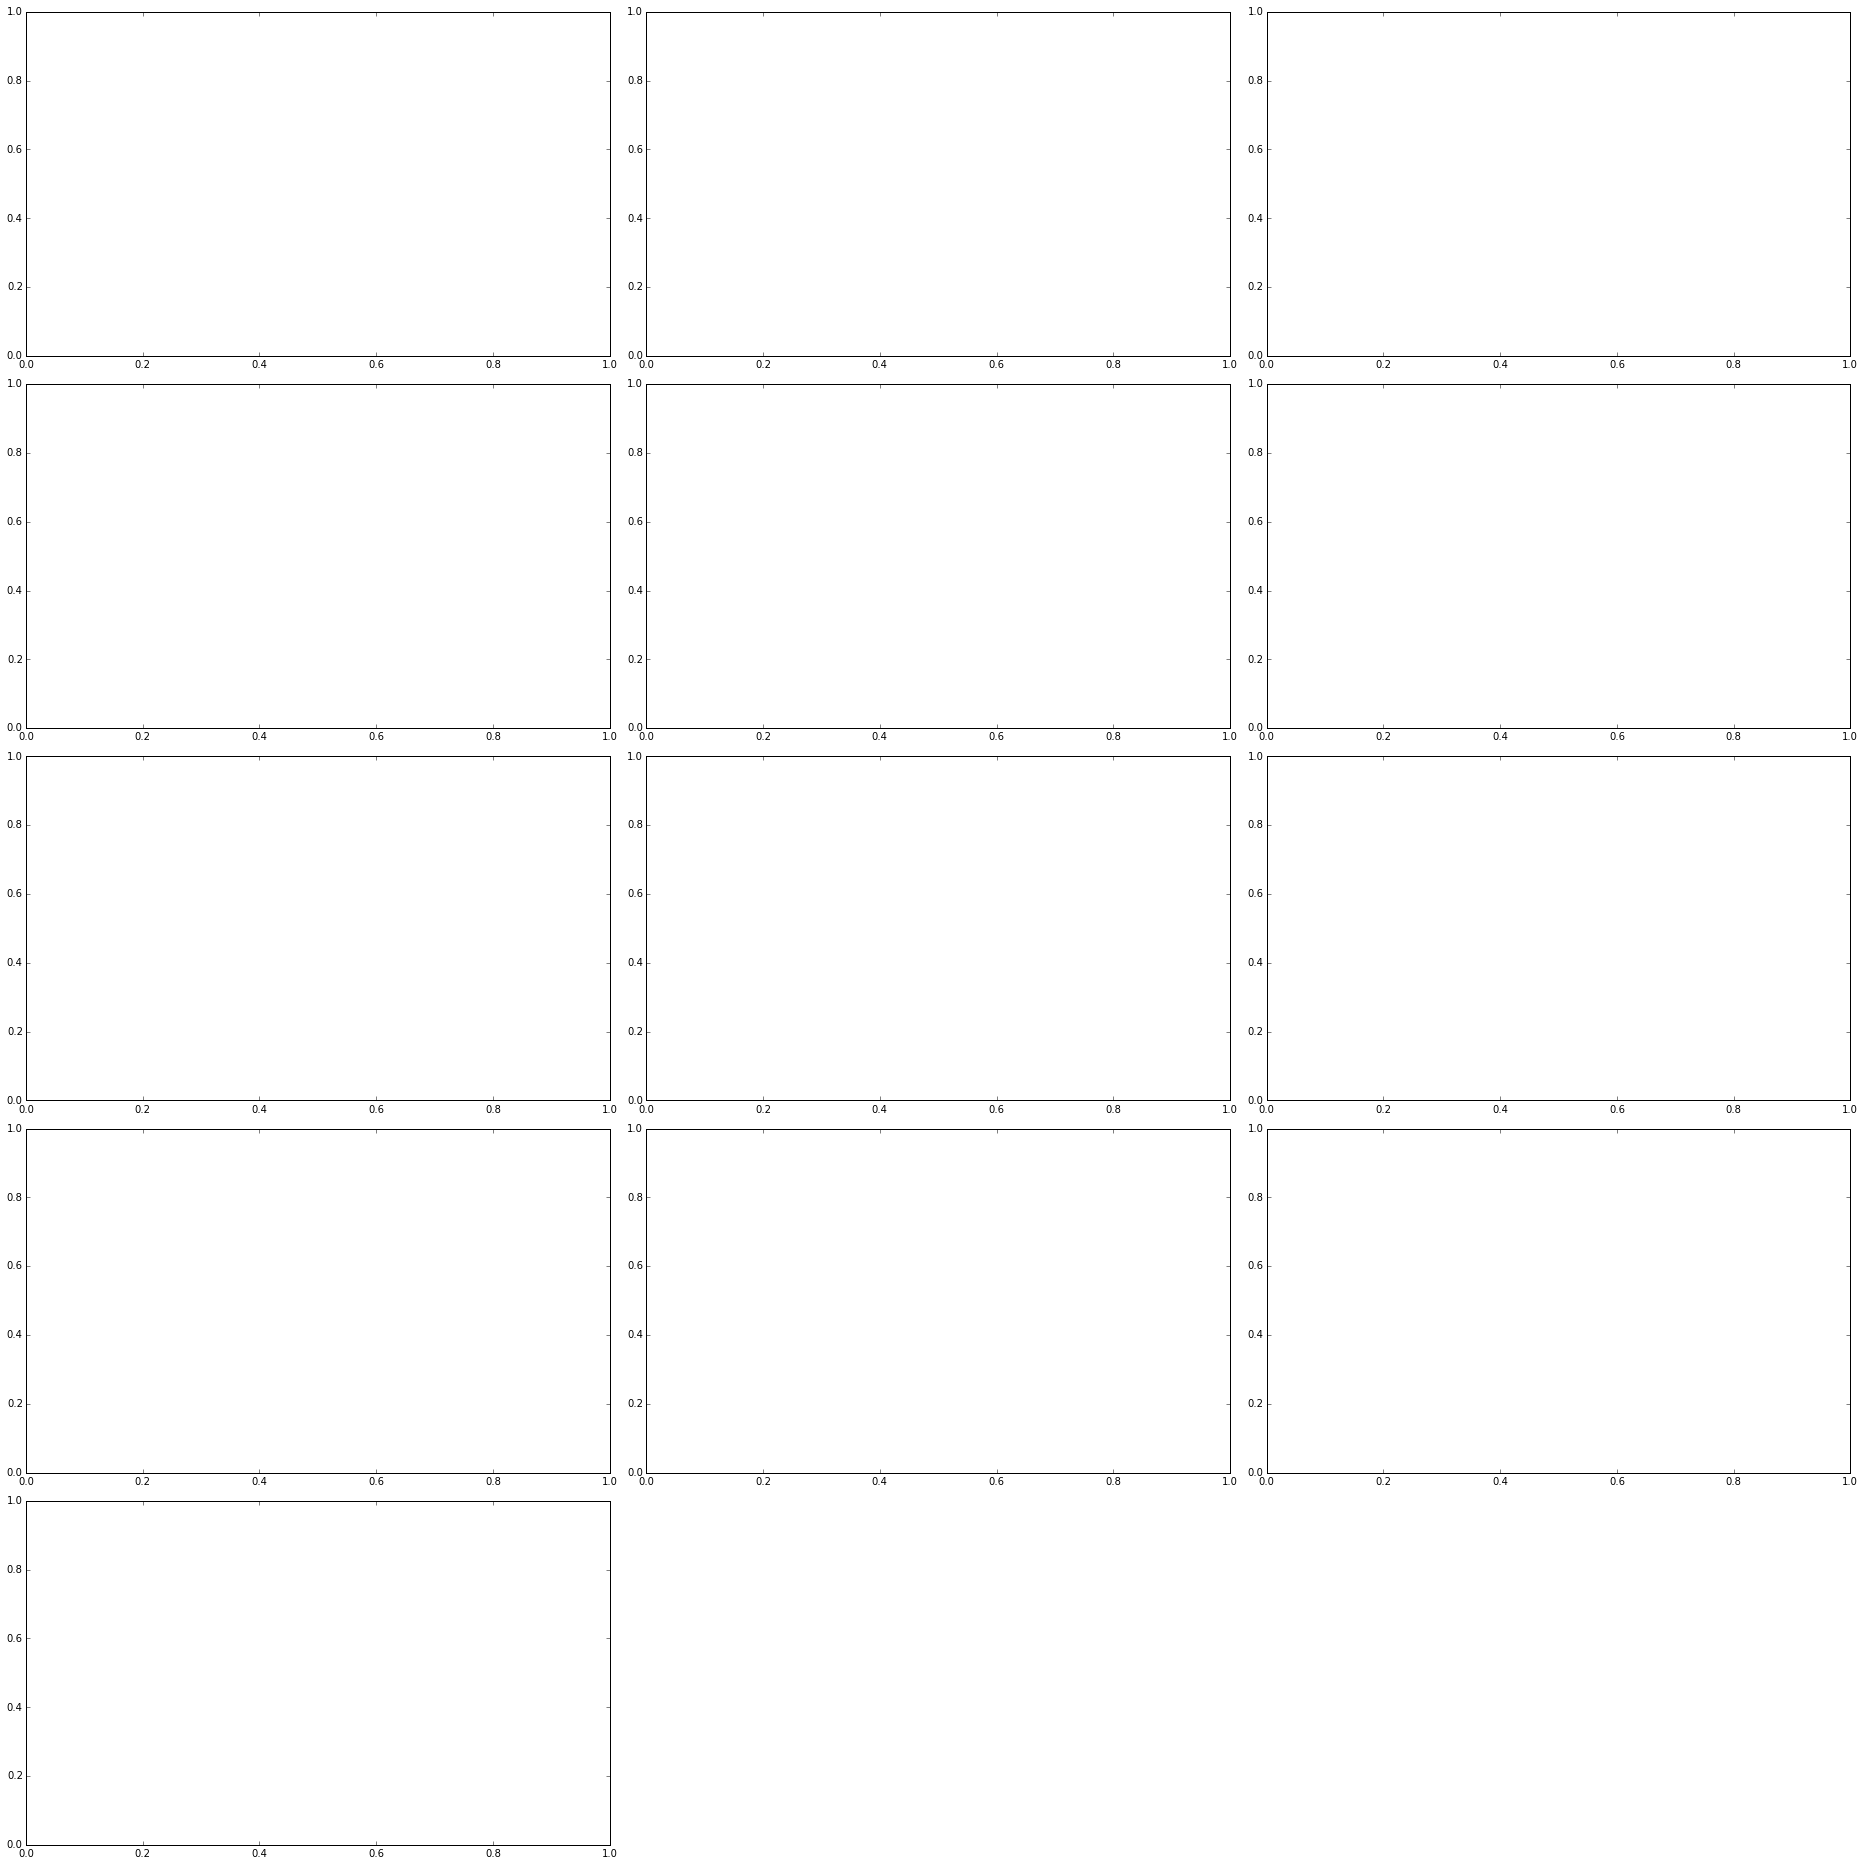

In [632]:
fig = plt.figure(figsize= (20,number_of_plots*2))
for i in range(1,number_of_plots+1,1):
    fig.add_subplot(n_rows,n_cols,i)



plt.tight_layout()
plt.show()

In [32]:
def Final_Ustacks_command(M_value, m_value, parent_dir_path):
       
## Define execute function ##
        
    def execute(bash_file):
        f = open(str(bash_file), 'r')
        script = f.read()
        subprocess.call(script, shell=True)
        print script
    
## Get files ##
    
    sample_names = []
    
    for i in os.listdir(parent_dir_path):
        if i.endswith(".fq_1") or i.endswith("1.fastq"): 
            sample_names.append(i)
    
    print ("Parameter values: M ="+str(M_value)+" m ="+str(m_value)+"\n")
    
## Write file ##

    f = open(str(parent_dir_path +"Final_Ustacks_commands.sh"), 'w') ## .. make a bash script file in the current ipython directory...
    f.write("#!/bin/bash\n\nmkdir "+ parent_dir_path + "Final_Ustacks_outputs/ \n") 
    
    Sample_ID = 1
    for sample in sample_names: ## so for each sample ...
        final_command_list = []
        f.write('ustacks -t fastq -M '+str(M_value)+' -m '+str(m_value)+' -p 8 -d -r -i '+str(Sample_ID)+' -f '+ str(parent_dir_path) + str(sample)+' -o '+ str(parent_dir_path) + 'Final_Ustacks_outputs/ \n')    
        Sample_ID += 1
        print (sample.split("_")[0]+" ID = "+str(Sample_ID))
    f.close()
    
## Execute the scripts
    execute(str(parent_dir_path +"Final_Ustacks_commands.sh"))

In [ ]:
Final_Ustacks_command(8,8,'/media/dan/34D5D1CE642D7E36/2013076_Hanfling_Bernd/Stacks/Stacks_analyses_V3/Incremental_tests/Batch_2/all_cru/')